# Recommendations with IBM

In this notebook, we´ve created a recommendation engine based on real data from the IBM Watson Studio platform. 



## Table of Contents

1. [Preliminary Wrangling](#Preliminary_Wrangling)<br>
1.a.-[Gathering Data](#Gathering_Data)<br>
1.b.-[Assesing and Cleaning Data](#Assesing_cleaning_data)<br>
2. [Exploratory Data Analysis](#EDA)<br>
3. [Rank Based Recommendations](#Rank)<br>
4. [User-User Based Collaborative Filtering](#User-User)<br>
5. [Reflection](#Reflection)<br>

## <a class="anchor" id="Preliminary_Wrangling">Part 1: Preliminary Wrangling


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

### <a class="anchor" id="Gathering_Data"> 1.a.- Gathering Data

In [4]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [5]:
#I show one example with the full text
i = 10
print("Doc full name: ",df_content['doc_full_name'][i])
print("Doc description: ",df_content['doc_description'][i])

Doc full name:  Offline-First iOS Apps with Swift & Cloudant Sync; Part 1: The Datastore
Doc description:  Apple's sample app, Food Tracker, taught you iOS. Now, take it further and sync data between devices, through the cloud, with an offline-first design.


### <a class="anchor" id="Assesing_cleaning_data"> 1.b.- Asessing and cleaning data

#### Incorrect Datatypes

`1.` Changing **article id** datatype to int

In [3]:
df.article_id = df.article_id.astype('int')
df.article_id = df.article_id.astype('str')
df_content.article_id = df_content.article_id.astype('str')

`2.` Mapping the **email with a user_id** column and remove the email column from the df dataframe

In [4]:
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


`3.` Dropping **Duplicates**

In [ ]:
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)

### <a class="anchor" id="EDA">Part II : Exploratory Data Analysis</a>

In this section I´ll provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  

In [5]:
df_interacts = df.groupby('user_id').count()['article_id']
print("The main characteristics of the distribution of how many user interacts with is")
print(df_interacts.describe())
mean_val = df_interacts.mean() 
print("The average number of interactions is", round(mean_val,2), "articles per user")
median_val = df_interacts.median() 
print("50% of individuals interact with", median_val, "number of articles or fewer")
max_views_by_user = df_interacts.max()# The maximum number of user-article interactions by any 1 user is ______.
print("The maximum number of user-article interactions by any 1 user is",max_views_by_user )

The main characteristics of the distribution of how many user interacts with is
count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64
The average number of interactions is 8.93 articles per user
50% of individuals interact with 3.0 number of articles or fewer
The maximum number of user-article interactions by any 1 user is 364


In the next histogram we can see it´s a high right skewed distribution

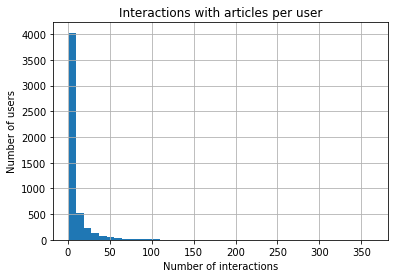

In [6]:
df_interacts.hist(bins = 40);
plt.xlabel('Number of interactions');
plt.ylabel('Number of users');
plt.title('Interactions with articles per user');

Let´s zoom it to see better than most of the users have less than 5 interactions, as we´ve seen before the median is 3 interactions

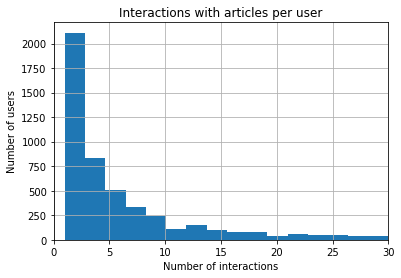

In [7]:
df_interacts.hist(bins = 200);
plt.xlabel('Number of interactions');
plt.ylabel('Number of users');
plt.title('Interactions with articles per user');
plt.xlim(0, 30);

`2.` More important information about the interactions between users and articles 

In [9]:
total_articles = len(df_content.article_id.unique())
unique_articles = len(df.article_id.unique())
non_interaction_articles = total_articles -unique_articles
print("The number of unique articles on the IBM platform is", total_articles, ", having interactions with users",
      unique_articles, "of them, so there are", non_interaction_articles, "articles that users haven´t interacted with" )
unique_users = len(df.user_id.unique())
user_article_interactions = len(df)
print("The number of unique users is", unique_users,"and the total number of user-article interactions is", user_article_interactions)

The number of unique articles on the IBM platform is 1051 , having interactions with users 714 of them, so there are 337 articles that users haven´t interacted with
The number of unique users is 5149 and the total number of user-article interactions is 45993


`3.` Let´s see which is the most viewed article.

In [10]:
df_article_views = df.groupby(['article_id','title']).count().reset_index().sort_values(by=['user_id'],ascending = False)
df_article_views.columns = ['article_id', 'title','n_views']
most_viewed_article_id = df_article_views.iloc[0][0]
max_views = df_article_views.n_views.max()
print("The most viewed article in the dataset is the id", most_viewed_article_id, "with",max_views, "views")  

The most viewed article in the dataset is the id 1429 with 937 views


### <a class="anchor" id="Rank">Part III: Rank-Based Recommendations</a>

`1.` Creation of two functions to return the **n** top articles ordered with most interactions as the top. First function returns the names of the articles and the second the id´s

In [11]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df_article_views.iloc[:,1].head(n).tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df_article_views.iloc[:,0].head(n).tolist()
 
    return top_articles # Return the top article ids

In [12]:
get_top_articles(5)

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm']

In [13]:
get_top_article_ids(5)

['1429', '1330', '1431', '1427', '1364']

### <a class="anchor" id="User-User">Part IV: User-User Based Collaborative Filtering</a>


`1.` Creation of a function reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** only appear in each **row** once.


* Each **article** only shows up in one **column**.  


* **If a user has interacted with an article, then has a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article is a 1.  


* **If a user has not interacted with an item, has a zero where the user-row meets for that article-column**. 


In [14]:
# creation of the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    
    matrix = df.copy()
    matrix = pd.concat([matrix,pd.get_dummies(matrix.article_id)], axis = 1)
    matrix = matrix.drop(['title','article_id'], axis = 1)
    user_item = matrix.groupby('user_id').max().reset_index()
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [15]:
user_item

,user_id,0,100,1000,1004,1006,1008,101,1014,1015,...,977,98,981,984,985,986,990,993,996,997
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5144,5145,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5145,5146,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,5147,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,5148,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# creation of a function that with the user as input extracts the row in user_item and the number of articles
# creation of a function that with the user as input extracts the number of articles interacted
user_row = []
row = 0
for i in range(user_item.shape[0]):
    user_id = user_item.iloc[i][0]
    row = i
    sum_int = np.sum(user_item.iloc[i][1:])
    list = [row, user_id, sum_int]
    user_row.append(list)
user_row = pd.DataFrame(data=user_row)
user_row.columns = ['row', 'user_id','n_inter']

def find_row(user):
    n_row = user_row[user_row['user_id'] == user]['row'].iloc[0]
    return n_row

def find_n_inter(user):
    n_inter = user_row[user_row['user_id'] == user]['n_inter'].iloc[0]
    return n_inter

`2.` Creation of a function that takes a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result doesn´t contain the provided user_id, as we know that each user is similar to him/herself. 

In [17]:
def find_similar_users(userid, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    u = user_item[user_item.user_id == userid].iloc[0][1:].to_frame().T
    v = user_item.drop('user_id', axis = 1).T
    similar = np.dot(u,v)
    similar = pd.DataFrame(data=similar.flatten())
    similar.columns = ['coinc']
    similar = pd.concat([user_row,similar], axis = 1)
    similar = similar.sort_values(by=['coinc'], ascending = False)
    similar.drop(similar[similar.user_id == userid].index, axis=0, inplace=True)
    most_similar_users = similar['user_id'].tolist()

       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [18]:
# A few tests for the function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that we have a function that provides the most similar users to each user, we want to use these users to find articles that can be recommended.  

In [82]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []

    for i in range(len(article_ids)):
        id =article_ids[i]
        art = df[df.article_id == id]['title'].iloc[0]
        article_names.append(art)
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(userid, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    items = user_item.columns[1:].tolist()
    usr_item = user_item[user_item.user_id ==userid].iloc[0,1:].tolist()
    products = [a * b for a, b in zip(usr_item, items)]
    article_ids = [x for x in products if x]
    article_ids_int = [ int(x) for x in article_ids ]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names

def user_user_recs(userid, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''

    # I find the users similars to the user 
    user_similars = find_similar_users(userid)
    # I get the articles of user 1
    user_articles = get_user_articles(userid)[0]
    # I iniatilize the recommendations to 0
    num = 0
    recs = []

    # I iterate through the users
    for i in range(len(user_similars)-1):
        similar_articles = get_user_articles(user_similars[i])[0]
        new_recs = [item for item in similar_articles if item not in user_articles]
        n_recs = len(new_recs)
        num = num + n_recs
        recs = set(recs+ new_recs)#sum the new recomendations to the actual and convert it to set for unique values
        recs = [*recs, ] #convert it to list
        if num >m:
            break
    recs = recs[:m]
    recs_int = [ int(x) for x in recs ][:m]
    return recs # return your recommendations for this user_id    

In [84]:
# Test
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['ml algorithm != learning machine',
 'awesome deep learning papers',
 'brunel interactive visualizations in jupyter notebooks',
 'shaping data with ibm data refinery',
 'using deep learning with keras to predict customer churn',
 'airbnb data for analytics: vancouver listings',
 'spark-based machine learning tools for capturing word meanings',
 'better together: spss and data science experience',
 'a tensorflow regression model to predict house values',
 'analyze energy consumption in buildings']

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [226]:
def get_top_sorted_users(userid, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    u = user_item[user_item.user_id == userid].iloc[0][1:].to_frame().T
    v = user_item.drop('user_id', axis = 1).T
    similar = np.dot(u,v)
    similar = pd.DataFrame(data=similar.flatten())
    similar.columns = ['coinc']
    similar = pd.concat([user_row,similar], axis = 1)
    similar.drop(similar[similar.user_id == userid].index, axis=0, inplace=True)
    similar.columns = ['row','neighbor_id','num_interactions','similarity']
    similar = similar.sort_values(by=['similarity', 'num_interactions'], ascending = False)
    neighbors_df = similar[['neighbor_id','similarity','num_interactions']]

    
    return neighbors_df # Return the dataframe specified in the doc_string

#I create a df with all the articles and their number of interactions
artic_interac = pd.DataFrame(df.groupby('article_id').count()['title']).reset_index()
artic_interac.columns = ['article_id','num_interac']
artic_interac.article_id = artic_interac.article_id.astype('int')
artic_interac.article_id = artic_interac.article_id.astype('str')

def user_user_recs_part2(userid, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # I find the users similars to the user 
    user_similars = get_top_sorted_users(userid)['neighbor_id']
    # I get the articles of user 
    user_articles = get_user_articles(userid)[0]
    # I iniatilize the recommendations to 0
    num = 0
    recs = []

    # I iterate through the users
    for i in range(len(user_similars)-1):
        similar_articles = get_user_articles(user_similars.iloc[i])[0]
        new_recs = [item for item in similar_articles if item not in user_articles]
        n_recs = len(new_recs)
        num = num + n_recs
        recs = set(recs+ new_recs)#sum the new recomendations to the actual and convert it to set for unique values
        recs = [*recs, ] #convert it to list
        if num >m:
            break
    
    recs = user_user_recs(userid, m)

    recs = pd.DataFrame(recs )
    recs.columns = ['article_id']
    recs['num_interac'] = 0

    for i in range(len(recs)-1):
        article = recs.article_id.iloc[i]
        recs['num_interac'][i] = artic_interac[artic_interac['article_id']== article]['num_interac'].iloc[0] 
        recs = recs.sort_values(by ='num_interac', ascending = False)

    recs = recs['article_id'].tolist()[:m]
    recs_int = [ int(x) for x in recs ][:m]


    recs_names = get_article_names(recs)
    
    return recs, recs_names

In [258]:
# Quick spot check
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1314', '1393', '1172', '1416', '34', '1298', '695', '444', '314', '1274']

The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo', 'the nurse assignment problem', 'apache spark lab, part 3: machine learning', 'united states demographic measures: population and age', 'top 10 machine learning use cases: part 1', 'from scikit-learn model to cloud with wml client', 'excel files: loading from object storage — python', 'declarative machine learning', 'some random weekend reading', 'data model with streaming analytics and python']


C:\Users\Telu Teruno\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
